In [32]:
import cv2
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import skimage.exposure
from skimage.filters import threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import disk
from skimage.segmentation import felzenszwalb
from skimage.measure import label

# Helper Functions

In [15]:
def downsample(img):
    norm = img/img.max()
    down = (norm*255).astype(np.uint8)
    return down
def downsample_time_series(df):
    down = [downsample(frame) for frame in df]
    return np.array(down)
def frame_sub(df):
    frames = len(df)
    sub = [df[i+1] - frame for i,frame in enumerate(df) if i+1 < frames]   
    return np.array(sub)
def estimate_bg(vid):
    med_bg = np.median(vid,axis=0)
    return med_bg
def dashview(images,max_cols=4):
    ''' Returns subplots in grid for inspection'''
    plots = len(images)    
    cols = plots
    if plots >= max_cols:
        cols = max_cols
    rows = ((plots-1)//max_cols) + 1
 
    # print(f"Generating {plots} [{rows} x {cols}] plots...")
        
    fig,axs = plt.subplots(ncols=cols,nrows=rows,
                           figsize=(20,20),squeeze=False,tight_layout=True)

    r,c = axs.shape
    for i in range(r):
        for j in range(c):
            flat_counter = (i*c)+j
            if flat_counter < plots:
                # print(f"Generating {flat_counter}")
                axs[i,j].imshow(images[flat_counter],cmap="gray")
            else:
                # print(f"{flat_counter} empty")
                axs[i,j].set_axis_off()

# Loading/Cleaning

In [9]:
vidpath = "multi_test.tif"
image_dir = "../inputs/images"
fullpath = f"{image_dir}/{vidpath}"

In [14]:
vid = tifffile.imread(fullpath)
vid = np.einsum("fcwh->cfwh",vid) # Nifty little trick to swap columns, nicer to have color channels first
colors, frames, width, height = vid.shape
ch1 = vid[0,:,:,:]
ch2 = vid[1,:,:,:]
ch3 = vid[2,:,:,:]
ch4 = vid[3,:,:,:]

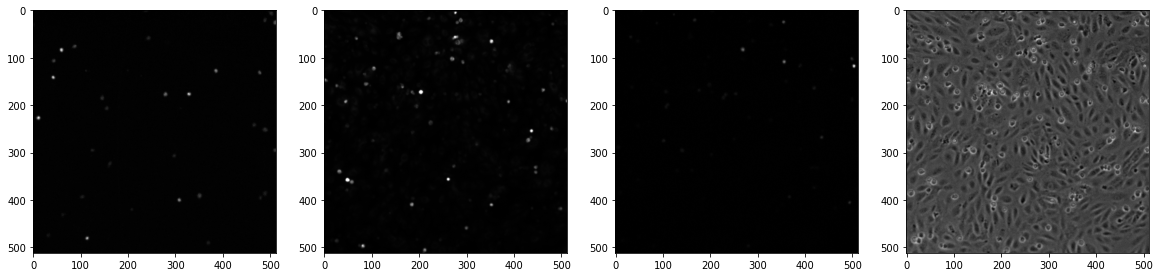

In [13]:
fig,axs = plt.subplots(1,4, figsize=(20,15))
for i,ax in enumerate(axs):
    ax.imshow(vid[i,0,:,:], cmap="gray")
plt.show()

# Preprocessing Pipeline
---
1. **Downsample**
2. **Histogram Equalization**
3. **Thresholding/Binarization**
4. **Morphological Filtering**
5. **Segmentation**

## 1. Downsample
---
* Is there a simple numpy,scikit function that can take care of this?
* Should I just apply this to the full stack from the get go?

In [ ]:
def downsample(img):
    norm = img/img.max()
    down = (norm*255).astype(np.uint8)
    return down
def downsample_time_series(df):
    down = [downsample(frame) for frame in df]
    return np.array(down)

## 2. Adaptive Histogram Equalization
---
* What kernel size should we choose?
* How can we choose this kernel size dynamically?

### Issues
---
* Channel 2 seems to have some crosstalk fluorecence between the endothelial cells and the T-cells

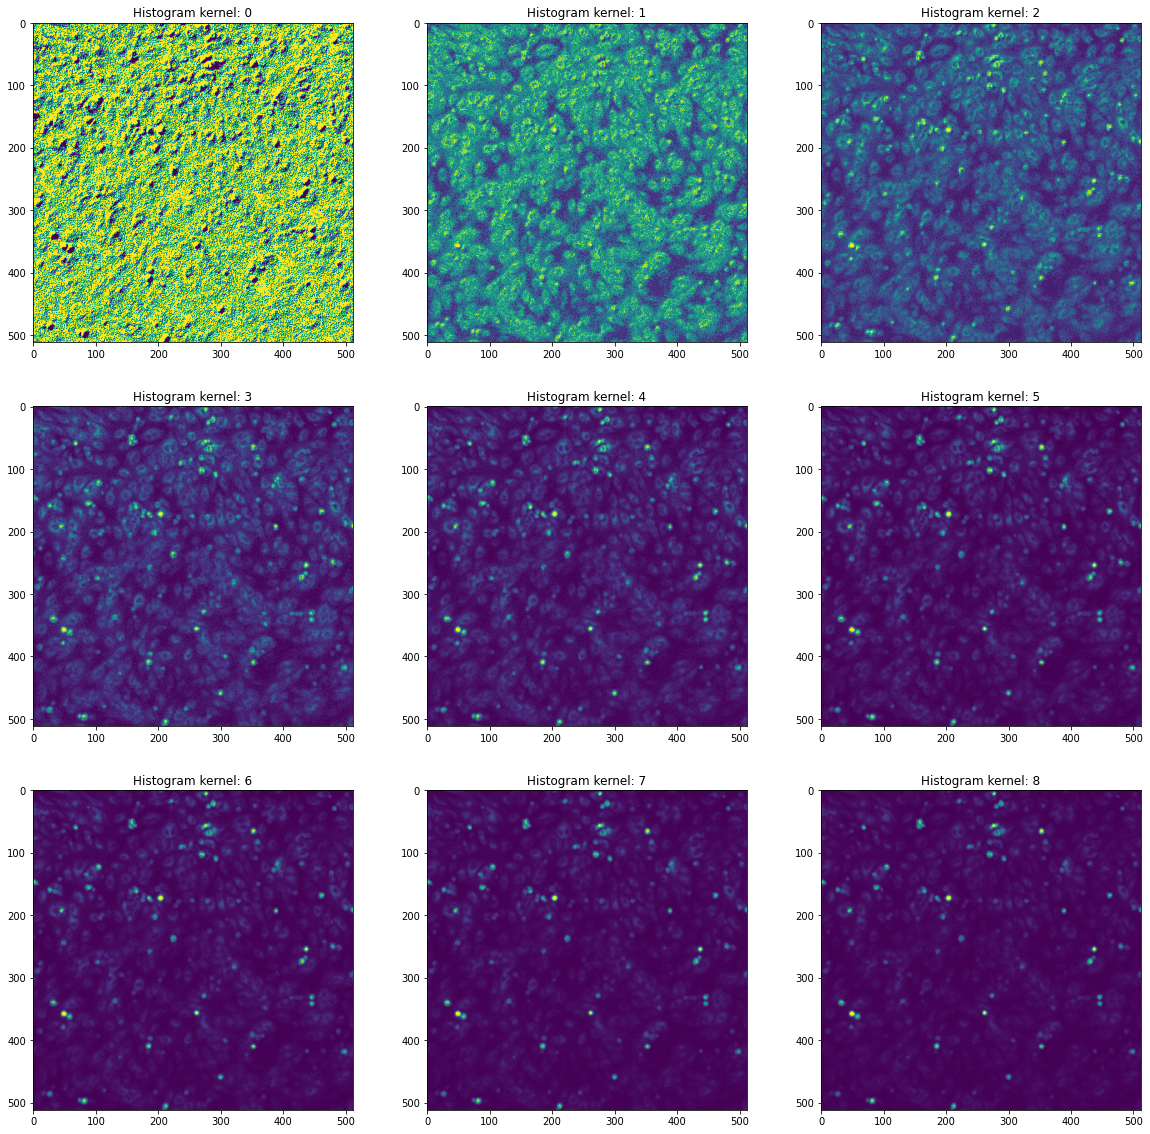

In [88]:
def test_hist(frame):
    d1 = downsample(frame)
    kernel_range=range(1,10)
    eqd = [skimage.exposure.equalize_adapthist(d1, kernel_size=k) for k in kernel_range]
    
    fig,axs = plt.subplots(3,3, figsize=(20,20))
    axs = axs.ravel()
    for i,ax in enumerate(axs):
        ax.imshow(eqd[i])
        ax.set_title(f"Histogram kernel: {i}")
        
    plt.show()
test_hist(ch2[0])

## 3. Thresholding/Binarization
---
* Currently using otsu with no parameters
* Better method/parameters?

## 4. Morphological Filtering
---
* Currently using **opening** to remove salt and close gaps.
* Need to figure out how to dynamically assign disk size

## 5. Segmenting
---
* Currently using the **measure.label** to label connected components
* Tried using the felzenthing but it was creating too many segments, and stacked upon each other

## >Full Pipeline<
---

In [ ]:
def binarize(frame, inspect=False):
    d1 = downsample(frame)
    eqd = skimage.exposure.equalize_adapthist(d1, kernel_size =7)
    thresh = threshold_otsu(eqd)
    binary = eqd > thresh
    selem = disk(2)
    opened = opening(binary, selem)
    
    if inspect:
        colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                  '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                  '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                  '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

        fig,ax = plt.subplots(2,2, figsize=(20,15))
        ax = ax.ravel()
        ax[0].imshow(d1, cmap="gray")
        ax[0].set_title("Original")

        ax[1].imshow(eqd, cmap="gray")
        ax[1].set_title("Hist Eq")

        ax[2].imshow(binary, cmap="gray")
        ax[2].set_title("Threshed Binary")

        ax[3].imshow(opened, cmap="gray")
        ax[3].set_title("Morpho: Opened")

        plt.show()
    return opened

# Notes
---
+ Need to throw out brightfield at some point, pretty useless in segmentation and counting atm
+ Need to put correct cell labels for each channel
+ Maybe a different way rather than multiple returns to handle counts and images
+ Maybe segment in a different method?

# Assays
---
1. **Simple off-rate by first/last counts**
2. **Cell tracking**

## 1. Off-rate Assay
---

### Issues
---
* Getting more cells after than before, might be an issues with histogram equalization or other preprocessing

In [60]:
def off_rate_counts(vid):
    cell_pop_names = ["Jurkats", "Tether", "PSGL1", "Brightfield"]
    cell_populations = {}
    imgs = {} # This hurts my soul to do it this way
    for i,cell_pop in enumerate(vid):
        first = binarize(cell_pop[0])
        last = binarize(cell_pop[-1])

        first, count_i = label(first,return_num=True)
        last, count_f = label(last,return_num=True)
        
        imgs[cell_pop_names[i]] = {"first": first, "last": last}
        cell_populations[cell_pop_names[i]] = {"first": count_i, "last": count_f}
        

    pops = pd.DataFrame(cell_populations)
    pops = pops.drop(columns=["Brightfield"])
    pops = pops.T # probably can set the dictionary up better initially
    return pops,imgs

In [61]:
pops,imgs = off_rate_counts(vid)

<AxesSubplot:>

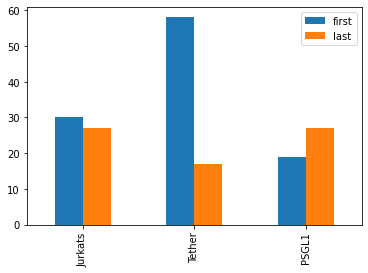

In [56]:
pops.T.plot.bar()

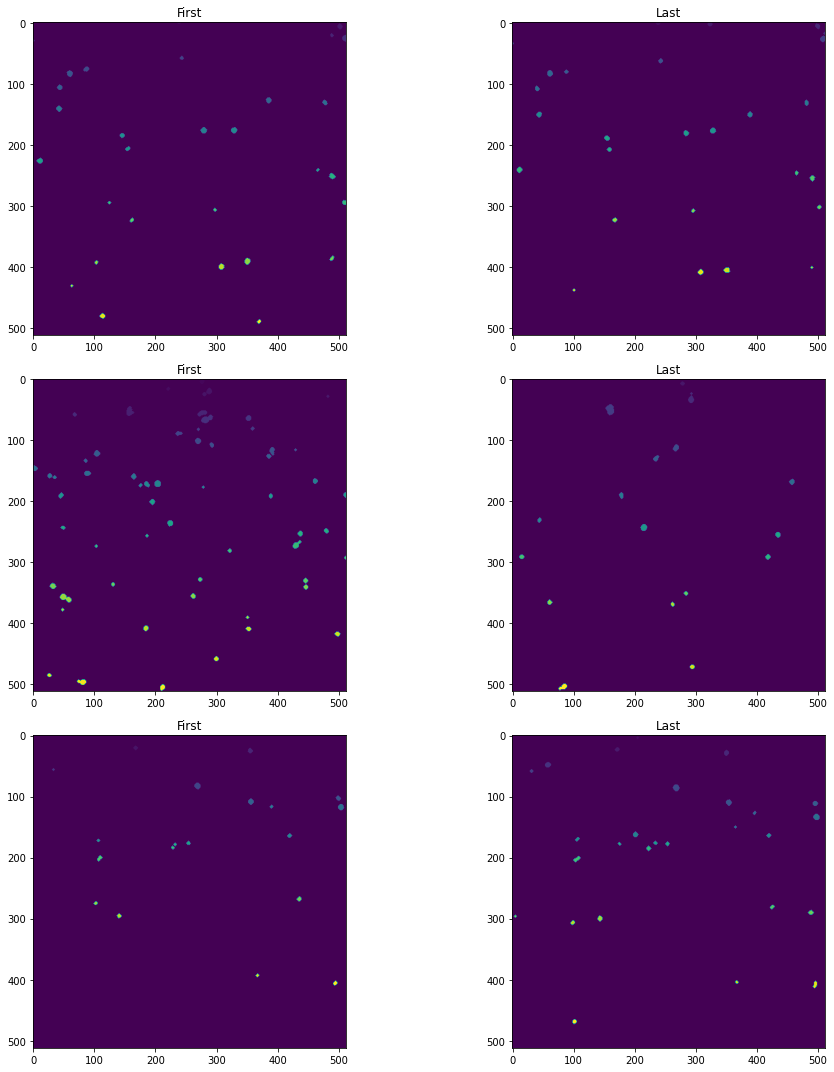

In [73]:
jurkats = imgs["Jurkats"]
tether = imgs["Tether"]
psgl1 = imgs["PSGL1"]

fig, axs = plt.subplots(3,2,figsize=(15,15))
axs = axs.ravel()
axs[0].imshow(jurkats["first"])
axs[0].set_title("First")
axs[1].imshow(jurkats["last"])
axs[1].set_title("Last")

axs[2].imshow(tether["first"])
axs[2].set_title("First")
axs[3].imshow(tether["last"])
axs[3].set_title("Last")

axs[4].imshow(psgl1["first"])
axs[4].set_title("First")
axs[5].imshow(psgl1["last"])
axs[5].set_title("Last")

fig.tight_layout()
plt.show()

# Previous stuff (Cell Tracking)
---
+ Some stuff here maybe reuseable? This was mostly trying to remove background to be able to segment off of the brightfield images but if we have accees to using fluorescence channels then this might not be necessary
+ We might not be able to get high enough temporal resolution for crawling with fluoresence?

In [ ]:
from skimage.filters import gaussian

In [ ]:
gray = downsample_time_series(vid)

In [ ]:
dashview(gray[:10*4:10])

In [ ]:
blurred = gaussian(gray[0],sigma=2)
plt.imshow(blurred,cmap="gray")
plt.show()

# Using first frame of video as background

## Issues:
+ Doesn't seem to work, in fact it creates a consistent background image across all frames

In [ ]:
bg_sub = np.array([(frame - frame0).astype(np.uint8) for frame in test8])

dashview(bg_sub[1:10*4+1:10])

In [ ]:
bg_sub.mean()

# Using median frame as background

In [ ]:
bg = estimate_bg(test8)
bg8 = bg.astype(np.uint8)
plt.imshow(bg,cmap="gray")
plt.show()

## Results

+ This doesn't seem to be doing much? I feel like the images are too bright, I think something went wrong here.

In [ ]:
med_sub = [frame - bg8 for frame in test8]
dashview(med_sub[:10*4:10])

In [ ]:
med_sub[0].dtype

In [ ]:
panel = [test8[0],bg,med_sub[0]]
panel_not = [np.bitwise_not(f) for f in panel]
dashview(panel)

In [ ]:
inv = np.bitwise_not(test8[0])
plt.imshow(inv, cmap="gray")
plt.show()